# TF-IDF

## Data Pre-processing

In [1]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

import nltk
import random
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

## Preprocess and tokenize text
def preprocess_and_tokenize(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    preprocessed_text = ' '.join(cleaned_tokens)  # For the preprocessed column
    return preprocessed_text, cleaned_tokens

##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=150):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_text = ' '.join(words[start_index:start_index + record_length])
        preprocessed_text, tokens = preprocess_and_tokenize(sample_text)

        samples.append({
            'Title': title,
            'Author': author,
            'Label': label,
            'Preprocessed_Text': preprocessed_text,
            'Tokens': tokens
        })

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")


#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/1342/pg1342-images.html",
             "https://www.gutenberg.org/cache/epub/2489/pg2489-images.html",
             "https://www.gutenberg.org/cache/epub/43/pg43-images.html",
             "https://www.gutenberg.org/cache/epub/174/pg174-images.html",
             "https://www.gutenberg.org/cache/epub/1661/pg1661-images.html",
             "https://www.gutenberg.org/cache/epub/36/pg36-images.html"]
df = create_dataframe(book_urls)



df

import pandas as pd

# Assuming `df` is your DataFrame created from `create_dataframe` function
# Example dictionary, replace 'Author A', 'Author B', etc., with actual author names and their genres
author_to_genre = {
    'Jane Austen': 'Classic Romance',
    'Herman Melville': 'Adventure/Sea Story',
    'Robert Louis Stevenson': 'Psychological Thriller/Mystery',
    'Oscar Wilde': 'Philosophical Fiction',
    'Arthur Conan Doyle': 'Mystery/Detective Fiction',
    'H. G. Wells': 'Science Fiction'

    # Add more mappings as needed
}

# Function to map each author to a genre
def map_genre(author):
    return author_to_genre.get(author, 'Unknown')  # Default genre if author not found

# Apply the function to create a new 'Genre' column based on 'Author' column
df['Genre'] = df['Author'].apply(map_genre)

df



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,Author,Label,Preprocessed_Text,Tokens,Genre
0,Pride and Prejudice,Jane Austen,a,say p peopl much said lucki p ye sir know go w...,"[say, p, peopl, much, said, lucki, p, ye, sir,...",Classic Romance
1,Pride and Prejudice,Jane Austen,a,div figcent width figur img imag unavail div c...,"[div, figcent, width, figur, img, imag, unavai...",Classic Romance
2,Pride and Prejudice,Jane Austen,a,result previou studi thing give miss austen re...,"[result, previou, studi, thing, give, miss, au...",Classic Romance
3,Pride and Prejudice,Jane Austen,a,tongu servant wait tabl judg better one househ...,"[tongu, servant, wait, tabl, judg, better, one...",Classic Romance
4,Pride and Prejudice,Jane Austen,a,near relat patro happen overhear gentleman men...,"[near, relat, patro, happen, overhear, gentlem...",Classic Romance
...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot glass overturn water trough movement langu...,"[lot, glass, overturn, water, trough, movement...",Science Fiction
1196,The War of the Worlds,H. G. Wells,f,see look detail clear peopl hous better go alo...,"[see, look, detail, clear, peopl, hous, better...",Science Fiction
1197,The War of the Worlds,H. G. Wells,f,strike breviti p martian alarm approach crowd ...,"[strike, breviti, p, martian, alarm, approach,...",Science Fiction
1198,The War of the Worlds,H. G. Wells,f,brute said good god ugli brute repeat p see ma...,"[brute, said, good, god, ugli, brute, repeat, ...",Science Fiction


## TF-IDF transformer

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA

# Transform text data into TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Preprocessed_Text'])
n_clusters = 6

encoder = LabelEncoder()
true_labels_encoded = encoder.fit_transform(df['Author'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


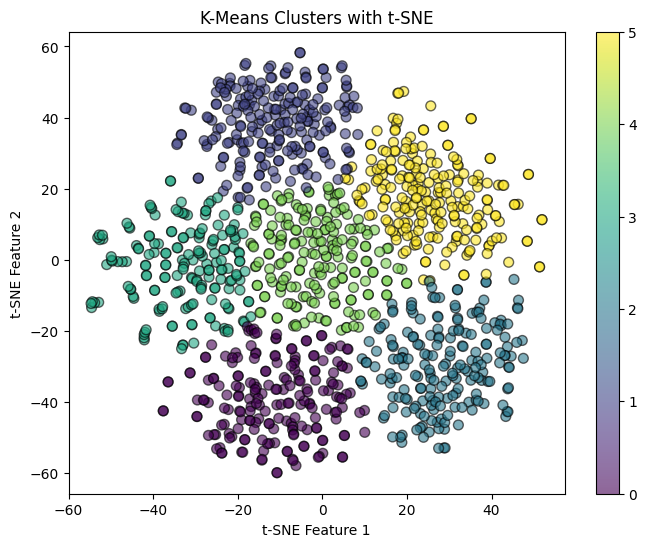

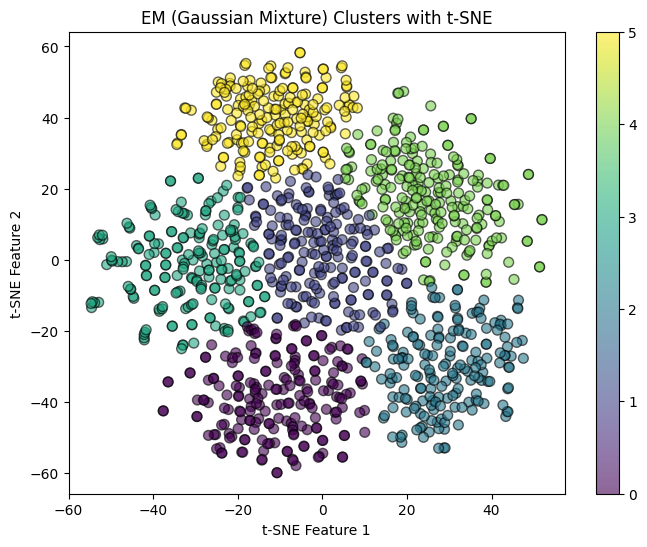

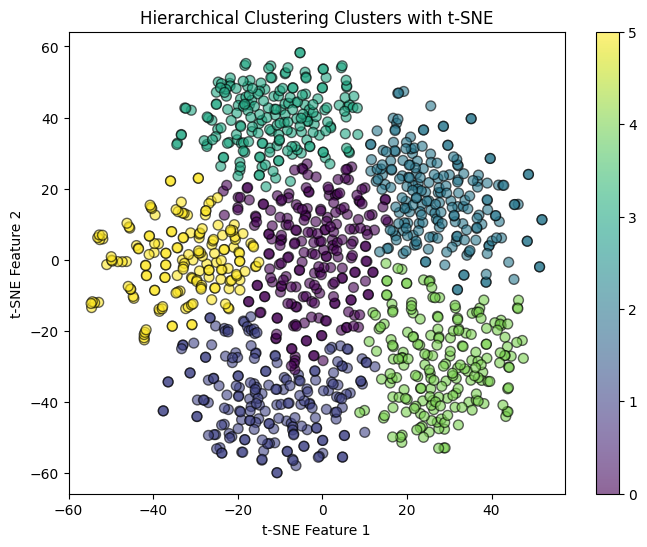

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())  # Assuming X is your TF-IDF matrix

# Define the clustering models
models = {
    "K-Means": KMeans(n_clusters=6, random_state=42),
    "EM (Gaussian Mixture)": GaussianMixture(n_components=6, random_state=42),
    "Hierarchical Clustering": AgglomerativeClustering(n_clusters=6)
}

# Plotting function for clusters
def plot_clusters_tsne(X, labels, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title(f'{model_name} Clusters with t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.colorbar()
    plt.show()

# Apply clustering and plot with t-SNE reduced data
for name, model in models.items():
    if name == "EM (Gaussian Mixture)":
        # Gaussian Mixture Model uses 'predict' to assign cluster labels
        model.fit(X_tsne)
        labels = model.predict(X_tsne)
    else:
        labels = model.fit_predict(X_tsne)

    plot_clusters_tsne(X_tsne, labels, name)


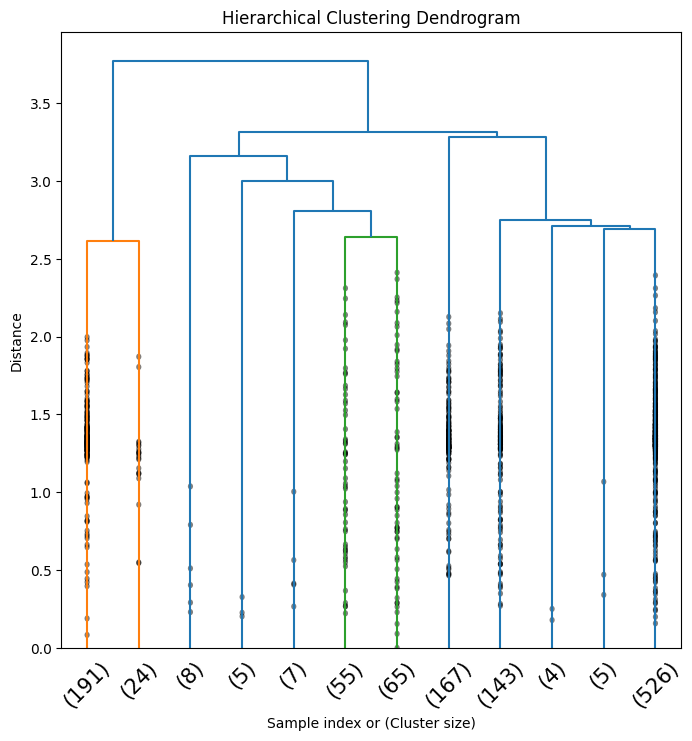

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix using the Ward's method
linkage_matrix = linkage(X.toarray(), 'ward')

plt.figure(figsize=(8, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()


# Evaluation metrics

In [5]:
# K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

silhouette_kmeans = silhouette_score(X, kmeans_labels)
kappa_kmeans = cohen_kappa_score(true_labels_encoded, kmeans_labels)

print(f"Evaluations metrics for K-means")
print(f"Silhouette Score for K-means: {silhouette_kmeans}")
print(f"Cohen's Kappa for K-means: {kappa_kmeans}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Evaluations metrics for K-means
Silhouette Score for K-means: 0.009162388053921932
Cohen's Kappa for K-means: -0.1259999999999999


In [6]:
# EM using Gaussian Mixture
gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(X.toarray())
gmm_labels = gmm.predict(X.toarray())
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

silhouette_gmm = silhouette_score(X, gmm_labels)
kappa_gmm = cohen_kappa_score(true_labels_encoded, gmm_labels)

print(f"Evaluations metrics for EM")
print(f"Silhouette Score for GMM: {silhouette_gmm}")
print(f"Cohen's Kappa for GMM: {kappa_gmm}")

Evaluations metrics for EM
Silhouette Score for GMM: 0.006391309408920688
Cohen's Kappa for GMM: 0.039999999999999925


In [7]:
# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(X.toarray())
agglo_labels = agglo.labels_
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

silhouette_agglo = silhouette_score(X, agglo_labels)
kappa_agglo = cohen_kappa_score(true_labels_encoded, agglo_labels)

print(f"Evaluations metrics for HC")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_agglo}")
print(f"Cohen's Kappa for Hierarchical Clustering: {kappa_agglo}")

Evaluations metrics for HC
Silhouette Score for Hierarchical Clustering: 0.006757789073093578
Cohen's Kappa for Hierarchical Clustering: 0.01000000000000012
